In [1]:
%pip install ultralytics
%pip install super-gradients
%pip install supervision
%pip install torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.2/721.2 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 44.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 54.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 41.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.7/86.7 kB 3.2 MB/s eta 0:00:00


In [2]:
from ultralytics import NAS

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from super_gradients.training import models
import torch
DEVICE = 'cuda' if torch.cuda.is_available() else "cpu"

model_path = '/content/drive/MyDrive/5Modelos_Yolov8_DatasetTumor/YoloNas-S'

best_model = models.get(
    'yolo_nas_s',
    num_classes=1,
    checkpoint_path=f"{model_path}/average_model.pth"
).to(DEVICE)


[2024-03-09 21:33:44] INFO - checkpoint_utils.py - Successfully loaded model weights from /content/drive/MyDrive/5Modelos_Yolov8_DatasetTumor/YoloNas-S/average_model.pth checkpoint.


In [ ]:
def calculate_iou(box1, box2):
    # Calcular a interseção
    x_intersection = max(0, min(box1[2], box2[2]) - max(box1[0], box2[0]))
    y_intersection = max(0, min(box1[3], box2[3]) - max(box1[1], box2[1]))
    area_intersection = x_intersection * y_intersection

    # Calcular a união
    area_box1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    area_box2 = (box2[2] - box2[0]) * (box2[3] - box2[1])
    area_union = area_box1 + area_box2 - area_intersection

    # Calcular a IoU
    iou = area_intersection / max(area_union, 1e-10)  # Evitar divisão por zero

    return iou

In [ ]:
import supervision as sv
import ultralytics
import numpy as np

def get_inference(path_project):
  ds = sv.DetectionDataset.from_yolo(
      images_directory_path=f"{path_project}/images",
      annotations_directory_path=f"{path_project}/labels",
      data_yaml_path=f"/content/drive/MyDrive/CsiLab-BrainTumor-Detection-3/data.yaml",
      force_masks=False
  )

  CONFIDENCE_TRESHOLD = 0.5
  predictions = {}
  for image_name, image in ds.images.items():
    result =best_model.predict(image, conf=CONFIDENCE_TRESHOLD)
    detections = sv.Detections(
        xyxy=result.prediction.bboxes_xyxy,
        confidence=result.prediction.confidence,
        class_id=result.prediction.labels.astype(int),
    )
    predictions[image_name] = detections

    nome_imagem = image_name.split('/')[7] + ".txt"
    np.savetxt(f"{model_path}/inferencias/{path_project.split('/')[5]}/{nome_imagem}",detections.xyxy, fmt= '%1.20f')

  for key in list(ds.images.keys()):
    # Para anotações
    annotation_detections = ds.annotations[key]
    for detection in annotation_detections:
      nome_imagem = (key.split('/')[7]).split('.jpg')[0] + ".txt"
      np.savetxt(f"{model_path}/anotacoes/{path_project.split('/')[5]}/{nome_imagem}",np.asarray(detection[0]).reshape(1,4), fmt= '%1.20f')



get_inference("/content/drive/MyDrive/CsiLab-BrainTumor-Detection-3/test")
get_inference("/content/drive/MyDrive/CsiLab-BrainTumor-Detection-3/train")
get_inference("/content/drive/MyDrive/CsiLab-BrainTumor-Detection-3/valid")

/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
[2024-03-09 21:33:44] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-03-09 21:33:46] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-03-09 21:33:47] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-03-09 21:33:48] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-03-09 21:33:49] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-03-09 21

In [ ]:
import os
import numpy as np
from statistics import mean
import pandas as pd

inference_paths = [f"{model_path}/inferencias/test",f"{model_path}/inferencias/train",f"{model_path}/inferencias/valid" ]
anotation_path = f"{model_path}/anotacoes"


iou_log = pd.DataFrame(columns=['Namelabel','LabelTrue','NamePredict','LabelPredict','iouResult'])

for inference_path in inference_paths:
  iou_result = []
  for filename in os.listdir(f"{inference_path}"):
    labels = (np.genfromtxt(os.path.join(f"{inference_path}", filename), dtype=float))  if np.shape(np.genfromtxt(os.path.join(f"{inference_path}", filename), dtype=float)) != (0,) else [0, 0, 0, 0]
    images = (os.path.join(f"{inference_path}", filename).split('/')[-1].split('.jpg')[0] +'.txt')
    label_v = (np.genfromtxt(os.path.join(f"{anotation_path}/{inference_path.split('/')[7]}", images), dtype=float))


    if np.shape(labels) == (4,):
      if np.shape(label_v) != (4,):
        iou_aux  = []
        for row in label_v:
          newRow = {'Namelabel': filename,
                    'LabelTrue':row,
                    'NamePredict': images,
                    'LabelPredict':labels,
                    'iouResult':calculate_iou(row,labels)}
          iou_log = iou_log.append(newRow, ignore_index=True)
          iou_aux.append(calculate_iou(row,labels))
        iou_result.append(max(iou_aux))
      else:
          newRow = {'Namelabel': filename,
                    'LabelTrue':label_v,
                    'NamePredict': images,
                    'LabelPredict':labels,
                    'iouResult':calculate_iou(label_v,labels)}
          iou_log = iou_log.append(newRow, ignore_index=True)
          iou_aux.append(calculate_iou(label_v,labels))
          iou_result.append(calculate_iou(label_v,labels))
    else:
      for label in labels:
        if np.shape(label_v) != (4,):
          iou_aux  = []
          for row in label_v:
            newRow = {'Namelabel': filename,
                      'LabelTrue':row,
                      'NamePredict': images,
                      'LabelPredict':label,
                      'iouResult':calculate_iou(row,label)}
            iou_log = iou_log.append(newRow, ignore_index=True)
            iou_aux.append(calculate_iou(row,label))
          iou_result.append(max(iou_aux))
        else:
            newRow = {'Namelabel': filename,
                      'LabelTrue':label_v,
                      'NamePredict': images,
                      'LabelPredict':label,
                      'iouResult':calculate_iou(label_v,label)}
            iou_log = iou_log.append(newRow, ignore_index=True)
            iou_aux.append(calculate_iou(label_v,label))
            iou_result.append(calculate_iou(label_v,label))


  with(open(f"{model_path}/iouMean_{inference_path.split('/')[7]}.txt",'w')) as file:
    file.write(str(mean(iou_result)))

  print(iou_log['iouResult'].mean())
  iou_log.to_csv(f"{model_path}/LogIoU_{inference_path.split('/')[7]}.csv", index=False)


<ipython-input-202-71463a623d31>:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  iou_log = iou_log.append(newRow, ignore_index=True)
<ipython-input-202-71463a623d31>:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  iou_log = iou_log.append(newRow, ignore_index=True)
<ipython-input-202-71463a623d31>:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  iou_log = iou_log.append(newRow, ignore_index=True)
<ipython-input-202-71463a623d31>:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  iou_log = iou_log.append(newRow, ignore_index=True)
<ipython-input-202-71463a623d31>:38: FutureWarning: The frame.append method is deprecated and will be re

0.8491785688621667


<ipython-input-202-71463a623d31>:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  iou_log = iou_log.append(newRow, ignore_index=True)
<ipython-input-202-71463a623d31>:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  iou_log = iou_log.append(newRow, ignore_index=True)
<ipython-input-202-71463a623d31>:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  iou_log = iou_log.append(newRow, ignore_index=True)
<ipython-input-202-71463a623d31>:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  iou_log = iou_log.append(newRow, ignore_index=True)
<ipython-input-202-71463a623d31>:38: FutureWarning: The frame.append method is deprecated and will be re

0.8679114564720416


<ipython-input-202-71463a623d31>:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  iou_log = iou_log.append(newRow, ignore_index=True)
<ipython-input-202-71463a623d31>:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  iou_log = iou_log.append(newRow, ignore_index=True)
<ipython-input-202-71463a623d31>:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  iou_log = iou_log.append(newRow, ignore_index=True)
<ipython-input-202-71463a623d31>:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  iou_log = iou_log.append(newRow, ignore_index=True)
<ipython-input-202-71463a623d31>:38: FutureWarning: The frame.append method is deprecated and will be re

In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Função para gerar a matriz de confusão para um DataFrame
def generate_confusion_matrix(df):
    y_true = df['y_true'].values
    y_pred = df['y_pred'].values
    return confusion_matrix(y_true, y_pred)



'\n# Pasta contendo os arquivos Excel\nexcel_folder = "output_excel"\n\n# Lista de arquivos na pasta de Excel\nexcel_files = os.listdir(excel_folder)\n\n# Avaliar cada arquivo Excel\nfor excel_file in excel_files:\n    # Carregar o DataFrame do arquivo Excel\n    df = pd.read_excel(os.path.join(excel_folder, excel_file))\n\n    # Calcular a média do IoU\n    mean_iou = calculate_mean_iou(df)\n\n    # Contar quantos labels têm IoU maior que 0.5, 0.7 e 0.9\n    count_iou_05 = count_labels_iou(df, 0.5)\n    count_iou_07 = count_labels_iou(df, 0.7)\n    count_iou_09 = count_labels_iou(df, 0.9)\n\n    # Gerar a matriz de confusão\n    confusion_mat = generate_confusion_matrix(df)\n\n    # Salvar a matriz de confusão em um arquivo Excel\n    confusion_mat_df = pd.DataFrame(confusion_mat)\n    output_filename = excel_file.replace(\'.xlsx\', \'_confusion_matrix.xlsx\')\n    confusion_mat_df.to_excel(os.path.join(excel_folder, output_filename), index=False)\n\n    # Mostrar os resultados\n    p

<ipython-input-131-a4c7b62e2739>:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred_list.append(int(prediction_list[i].class_id))


[[275  12]
 [  0   0]]


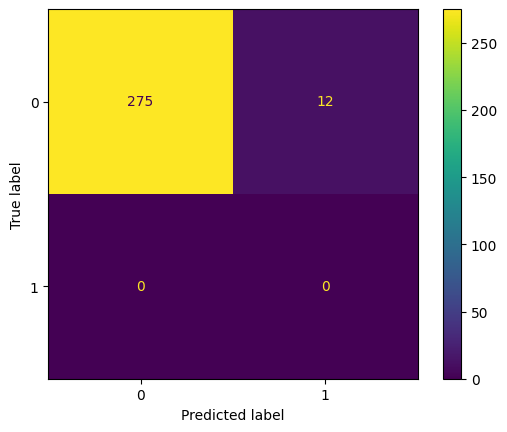

In [ ]:
data_true = np.loadtxt('/content/drive/MyDrive/5Modelos_Yolov8_DatasetTumor/Train6YoloNAS/detections.txt', dtype= str, delimiter = ',')
y_true_list = []
y_pred_list = []
for i in range(len(data_true)):
  y_true_list.append(int(data_true[i][7]))
  try:
    y_pred_list.append(int(prediction_list[i].class_id))
  except Exception as e:
    y_pred_list.append(1)

df = pd.DataFrame({"y_true":y_true_list,"y_pred":y_pred_list})
print(generate_confusion_matrix(df))
disp = ConfusionMatrixDisplay(generate_confusion_matrix(df))
disp.plot()


In [ ]:
#Validação_yoloNAS




In [8]:
%pip install ultralytics
%pip install onemetric
%pip install roboflow



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.4/71.4 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 8.7 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.9.0.80
    Uninstalling opencv-python-headless-4.9.0.80:
      Successfully uninstalled opencv-python-headless-4.9.0.80
  Attempting uninstall: idna
    Found existing installation: idna 3.6
    Uninstalling idna-3.6:
      Successfully uninstalled idna-3.6
  Attempting uninstall: cycler
    Found existing installation: cycler 0.12.1
    Uninstalling cycler-0.12.1:
      Successfully uninstalled cycler-0.

In [9]:

from roboflow import Roboflow
rf = Roboflow(api_key="OZmt7veKofDCRjgyQ5XE")
project = rf.workspace("csilab").project("csilab-braintumor-detection")
dataset = project.version(3).download("yolov8")

loading Roboflow workspace...
loading Roboflow project...
Dependency ultralytics==8.0.196 is required but found version=8.1.27, to fix: `pip install ultralytics==8.0.196`


Extracting Dataset Version Zip to CsiLab-BrainTumor-Detection-3 in yolov8::   0%|          | 0/614 [00:00<?, ?it/s]

In [82]:
import torch
from super_gradients.training import Trainer

DEVICE = 'cuda' if torch.cuda.is_available() else "cpu"
MODEL_ARCH = 'yolo_nas_m'
BATCH_SIZE = 32
MAX_EPOCHS = 1000
CHECKPOINT_DIR = './checkpoints'
EXPERIMENT_NAME = project.name.lower().replace(" ", "_")

from super_gradients.training import Trainer

trainer = Trainer(experiment_name=EXPERIMENT_NAME, ckpt_root_dir=CHECKPOINT_DIR)

LOCATION = dataset.location
CLASSES = sorted(project.classes.keys())

dataset_params = {
    'data_dir': LOCATION,
    'train_images_dir':'train/images',
    'train_labels_dir':'train/labels',
    'val_images_dir':'valid/images',
    'val_labels_dir':'valid/labels',
    'test_images_dir':'test/images',
    'test_labels_dir':'test/labels',
    'classes': CLASSES
}
print(dataset_params['classes'])


['Tumor']


In [83]:
from super_gradients.training.dataloaders.dataloaders import (coco_detection_yolo_format_train, coco_detection_yolo_format_val)

train_data = coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['train_images_dir'],
        'labels_dir': dataset_params['train_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size': BATCH_SIZE,
        'num_workers': 12
    }
)

val_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['val_images_dir'],
        'labels_dir': dataset_params['val_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size': BATCH_SIZE,
        'num_workers': 12
    }
)

test_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['test_images_dir'],
        'labels_dir': dataset_params['test_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size': BATCH_SIZE,
        'num_workers': 12
    }
)

[2024-03-14 17:22:01] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations: 100%|██████████| 211/211 [00:00<00:00, 2413.85it/s]
[2024-03-14 17:22:02] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations: 100%|██████████| 60/60 [00:00<00:00, 1475.03it/s]
[2024-03-14 17:22:02] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.


In [84]:
from super_gradients.training import models

model = models.get(
    MODEL_ARCH,
    num_classes=len(dataset_params['classes']),
    pretrained_weights="coco"
)

[2024-03-14 17:22:04] WARNING - checkpoint_utils.py - :warning: The pre-trained models provided by SuperGradients may have their own licenses or terms and conditions derived from the dataset used for pre-training.
 It is your responsibility to determine whether you have permission to use the models for your use case.
 The model you have requested was pre-trained on the coco dataset, published under the following terms: https://cocodataset.org/#termsofuse
[2024-03-14 17:22:04] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.
[2024-03-14 17:22:05] INFO - checkpoint_utils.py - Successfully loaded pretrained weights for architecture yolo_nas_m


In [85]:
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import DetectionMetrics_050

from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback

train_params = {
    'silent_mode': False,
    "average_best_models":True,
    "warmup_mode": "linear_epoch_step",
    "warmup_initial_lr": 1e-6,
    "lr_warmup_epochs": 3,
    "initial_lr": 5e-4,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.1,
    "optimizer": "Adam",
    "optimizer_params": {"weight_decay": 0.0001},
    "zero_weight_decay_on_bias_and_bn": True,
    "ema": True,
    "ema_params": {"decay": 0.9, "decay_type": "threshold"},
    "max_epochs": MAX_EPOCHS,
    "mixed_precision": True,
    "loss": PPYoloELoss(
        use_static_assigner=False,
        num_classes=len(dataset_params['classes']),
        reg_max=16
    ),
    "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,
            num_cls=len(dataset_params['classes']),
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=1,
                nms_threshold=0.7
            )
        )
    ],
    "metric_to_watch": 'mAP@0.50'
}

In [86]:
best_model = models.get(
    MODEL_ARCH,
    num_classes=len(dataset_params['classes']),
    checkpoint_path="/content/drive/MyDrive/5Modelos_Yolov8_DatasetTumor/YoloNas-M/ckpt_best.pth"
).to(DEVICE)


[2024-03-14 17:22:17] INFO - checkpoint_utils.py - Successfully loaded model weights from /content/drive/MyDrive/5Modelos_Yolov8_DatasetTumor/YoloNas-M/ckpt_best.pth EMA checkpoint.


In [88]:

trainer.test(
    model=best_model,
    test_loader=test_data,
    test_metrics_list=DetectionMetrics_050(
        score_thres=0.1,
        top_k_predictions=300,
        num_cls=len(dataset_params['classes']),
        normalize_targets=True,
        post_prediction_callback=PPYoloEPostPredictionCallback(
            score_threshold=0.1,
            nms_top_k=300,
            max_predictions=2,
            nms_threshold=0.3
        )
    )
)


Testing: 100%|██████████| 1/1 [00:06<00:00,  6.33s/it]

{'Precision@0.50': 0.4736842215061188,
 'Recall@0.50': 0.8999999761581421,
 'mAP@0.50': 0.8880905508995056,
 'F1@0.50': 0.6206896901130676,
 'Best_score_threshold': 0.550000011920929}

Testing: 100%|██████████| 1/1 [00:07<00:00,  7.98s/it]
